In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
np.random.seed(42)

n = 50000

# יצירת user_id
user_id = np.arange(1, n+1)

# גילאים מ-18 עד 70
age = np.random.randint(18, 70, n)

# תאריכי הרשמה בשנתיים האחרונות
start_date = datetime(2023, 1, 1)
end_date = datetime(2024, 6, 30)
signup_dates = [start_date + timedelta(days=int(x)) 
                for x in np.random.randint(0, (end_date - start_date).days, n)]

# תאריך פעילות אחרונה
last_active_dates = []
for d in signup_dates:
    # בין יום ההרשמה ועד שנה קדימה
    offset = np.random.randint(0, 365)
    last_active_dates.append(d + timedelta(days=offset))

# days since last active
days_since_last_active = [(datetime(2024, 7, 1) - d).days for d in last_active_dates]

# total transactions
total_transactions = np.random.poisson(3, n)

# total deposits
total_deposits = np.random.poisson(1, n)

# avg transaction amount
avg_transaction_amount = np.round(np.random.uniform(5, 200, n), 2)

# session count
session_count = np.random.poisson(5, n)

# device type
device_type = np.random.choice(["ios", "android", "web"], n, p=[0.4, 0.4, 0.2])

# premium
is_premium = np.random.choice([0, 1], n, p=[0.85, 0.15])

# churn rule: אם המשתמש לא היה פעיל יותר מ-45 ימים → נטש
churn = (np.array(days_since_last_active) > 45).astype(int)

df_churn = pd.DataFrame({
    "user_id": user_id,
    "age": age,
    "signup_date": signup_dates,
    "last_active_date": last_active_dates,
    "days_since_last_active": days_since_last_active,
    "total_transactions": total_transactions,
    "total_deposits": total_deposits,
    "avg_transaction_amount": avg_transaction_amount,
    "session_count": session_count,
    "device_type": device_type,
    "is_premium": is_premium,
    "churn": churn
})

df_churn.head()


,user_id,age,signup_date,last_active_date,days_since_last_active,total_transactions,total_deposits,avg_transaction_amount,session_count,device_type,is_premium,churn
0,1,56,2024-03-24,2025-02-04,-218,1,1,129.65,7,ios,0,0
1,2,69,2023-03-24,2023-05-23,405,3,0,164.19,8,android,0,1
2,3,46,2024-01-14,2024-07-04,-3,4,1,114.63,5,ios,1,0
3,4,32,2024-04-02,2024-04-28,64,3,0,102.90,10,android,0,1
4,5,60,2023-03-22,2024-01-23,160,5,2,97.16,2,web,0,1


In [2]:
df_churn.to_csv("fintech_churn_dataset.csv", index=False)


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

#הגדרת תכונות ועמודת מטרה
# X כל המאפיינים שישפיעו על החיזוי
# Y התוצאה שאנו רוצים
X = df_churn.drop(columns=["churn", "signup_date", "last_active_date", "user_id"])
y = df_churn["churn"]

# זיהוי עמודות קטגוריות
categorical = ["device_type"]
numeric = [col for col in X.columns if col not in categorical]

# מודלים מבינים רק מספרים ולכן אנחנו רוצים להמיר את כל העמודות הקטגוריאליות למספרים
preprocess = ColumnTransformer(transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OneHotEncoder(drop='first'), categorical) ])

#  חלוקה לנתוני מבחן ונתוני אימון
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_train.shape, X_test.shape


((37500, 8), (12500, 8))

In [4]:
from sklearn.linear_model import LogisticRegression

# מנקים נתונים, הופכים ערכים לסטנדרט, ממירים לקטוגריות, הופכים טקסט למספרים
#Pipeline יודע לקחת דאטה גולמי ולהפוך אותו מוכן למודל. 
model = Pipeline(steps=[
    ('preprocess', preprocess),
    ('logreg', LogisticRegression(max_iter=1000)) # לומד מהאימון מה המודל עושה, מבין מה מנבא נטישה, בונה פו' הסתברות
])

model.fit(X_train, y_train) # כאן המודל לומד מה מנבא נטישה, בפועל הוא לומד משקל כל פיצ'ר, מבין פיצ'רים חזקים, מפיק הסתברויות


,steps,"[('preprocess', ...), ('logreg', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [5]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[[5110    1]
 [   1 7388]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5111
           1       1.00      1.00      1.00      7389

    accuracy                           1.00     12500
   macro avg       1.00      1.00      1.00     12500
weighted avg       1.00      1.00      1.00     12500



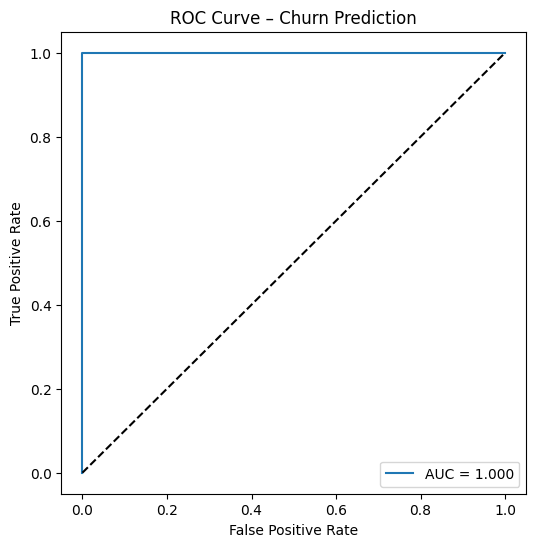

In [6]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Churn Prediction")
plt.legend()
plt.show()


In [7]:
import numpy as np

# שמות הפיצ'רים אחרי עיבוד
feature_names = numeric + list(model.named_steps['preprocess']
                               .named_transformers_['cat']
                               .get_feature_names_out())

importance = model.named_steps['logreg'].coef_[0]

sorted_indices = np.argsort(np.abs(importance))[::-1]

for idx in sorted_indices[:10]:
    print(f"{feature_names[idx]}: {importance[idx]:.4f}")


days_since_last_active: 27.9443
avg_transaction_amount: -0.0506
device_type_web: -0.0462
total_deposits: -0.0132
is_premium: -0.0087
device_type_ios: -0.0083
age: 0.0076
session_count: 0.0075
total_transactions: -0.0047
